### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

![ab_split](tm1.png "TM1")

### Переходим к практике

In [160]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

Наши новости

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [86]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lqw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

morph = pymorphy2.MorphAnalyzer()

151


In [9]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-10-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 21.1 s


In [12]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 43s


А теперь в 3 строчки обучим нашу модель

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

In [14]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [15]:
common_dictionary[19]

'директор'

Все просто - это словарь наших слов

Запускаем обучение

In [16]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 42.5 s


In [17]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.14792211),
 (6, 0.026630748),
 (11, 0.027951986),
 (15, 0.033735327),
 (20, 0.52869487),
 (24, 0.21805444)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints O[(20,
#   '0.016*"памятник" + 0.015*"пресссекретарить" + 0.015*"украина" + 0.014*"белоруссия" + 0.013*"общество" + 0.013*"квартира" + 0.010*"путин" + 0.010*"nn" + 0.010*"песок" + 0.009*"владимир"')nly Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: лётчик этаж плата заработный римский сибирский норвежский
topic_1: запустить бомба специальный индия зуб святой образовать
topic_2: космос область завод предполагаться регион год правительство
topic_3: nn экипаж солнце км место японский час
topic_4: год фонд доход тыс млн экономика исследование
topic_5: россия который nn сша российский год это
topic_6: препарат фотография вирус мышь выдать кровь лекарство
topic_7: человек который журнал группа погибнуть результат это
topic_8: население федеральный год депутат москва государственный совет
topic_9: виза сатурн убивать лёд кит автобус джонсон
topic_10: пенсия продукция восток параметр сотрудничать лауреат ближний
topic_11: белоруссия ремонт фестиваль минск греция эстония городской
topic_12: антонов заполнить фунт новак сербия швейцария сербский
topic_13: год компания млрд рубль рынок рост млн
topic_14: год военный который суд дело это район
topic_15: nn это который пациент год век напомнить
topic_16: год это который наука эксперт

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [20]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))
    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [21]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])

In [22]:
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values

In [23]:
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]

In [24]:


topic_matrix.head(3)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.054949,0.0,0.0,0.000000,0.000000,0.756744,...,0.0,0.000000,0.012465,0.0,0.0,0.000000,0.083299,0.078379,0.0,0.0000
1,4896,0.0,0.0,0.0,0.173844,0.0,0.0,0.000000,0.202301,0.000000,...,0.0,0.054972,0.000000,0.0,0.0,0.000000,0.258723,0.000000,0.0,0.0000
2,4897,0.0,0.0,0.0,0.147361,0.0,0.0,0.026801,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.564011,0.000000,0.000000,0.0,0.2162


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [25]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [26]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [207]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [65]:
user_articles_list = eval(user_articles_list)

In [67]:
a=[doc_dict[doc_id] for doc_id in user_articles_list]

In [70]:
a[1].shape

(25,)

In [28]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.0143452 , 0.        , 0.03410412,
       0.10682078, 0.        , 0.05786216, 0.07214849, 0.        ,
       0.        , 0.        , 0.        , 0.00864525, 0.16138941,
       0.04282231, 0.03573248, 0.        , 0.08107967, 0.00326999,
       0.05478766, 0.00691453, 0.29734008, 0.01186294, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [29]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.010898,0.000000,0.039606,0.000000,0.313288,0.0,0.057636,0.066919,...,0.027436,0.115616,0.0,0.065020,0.011882,0.047785,0.004706,0.082021,0.016751,0.024748
1,u108690,0.003849,0.004599,0.005740,0.002044,0.038960,0.055631,0.0,0.088327,0.065922,...,0.109055,0.061123,0.0,0.107121,0.000000,0.051186,0.002035,0.242687,0.015092,0.000000
2,u108339,0.003083,0.002011,0.019866,0.012560,0.011746,0.129631,0.0,0.132394,0.067371,...,0.061636,0.028642,0.0,0.029954,0.000000,0.058687,0.015049,0.170470,0.002850,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [30]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [31]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.010898,0.000000,0.039606,0.000000,0.313288,0.0,0.057636,0.066919,...,0.115616,0.0,0.065020,0.011882,0.047785,0.004706,0.082021,0.016751,0.024748,0
1,u108690,0.003849,0.004599,0.005740,0.002044,0.038960,0.055631,0.0,0.088327,0.065922,...,0.061123,0.0,0.107121,0.000000,0.051186,0.002035,0.242687,0.015092,0.000000,1
2,u108339,0.003083,0.002011,0.019866,0.012560,0.011746,0.129631,0.0,0.132394,0.067371,...,0.028642,0.0,0.029954,0.000000,0.058687,0.015049,0.170470,0.002850,0.000000,1


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [34]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12013169, 0.05969078, 0.30069899, 0.28790076, 0.02796304,
       0.06283062, 0.11450404, 0.15832586, 0.1578113 , 0.24110821])

In [36]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.255953, F-Score=0.652, Precision=0.579, Recall=0.747


In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
import itertools

Confusion matrix, without normalization
[[1622  133]
 [  63  182]]


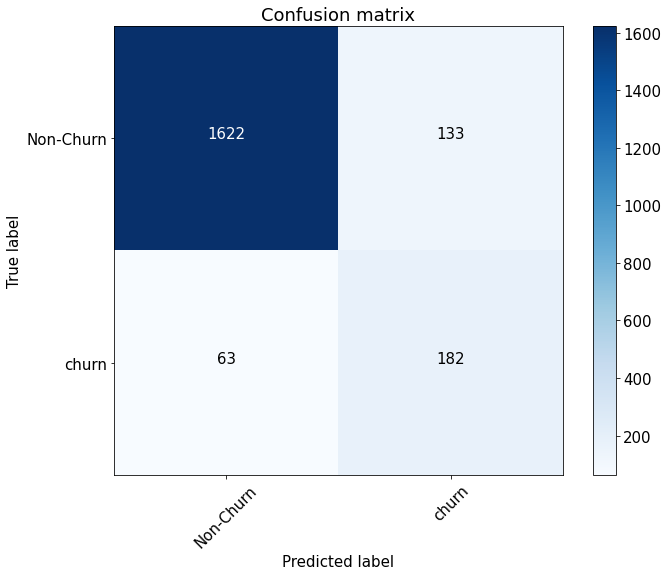

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
roc_auc_score(y_test, preds)

0.9355474155474156

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

# Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [42]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [43]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [44]:
def get_user_embedding_idf_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([tp[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [45]:
def get_user_embedding_df(fun):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(fun, 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    return user_embeddings


In [209]:
def test_result_learning(fun):
    user_embeddings = get_user_embedding_df(fun)
    X = pd.merge(user_embeddings, target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}, Precision={precision[ix]}, Recall={recall[ix]}')
    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    print(f'auc - {roc_auc_score(y_test, preds)}')
    return roc_auc_score(y_test, preds),fscore[ix],precision[ix],recall[ix]
                                                                      
    
    

In [203]:
result = {}

Best Threshold=0.2559528820630448, F-Score=0.6524064171122994, Precision=0.5791139240506329, Recall=0.746938775510204
Confusion matrix, without normalization
[[1622  133]
 [  63  182]]


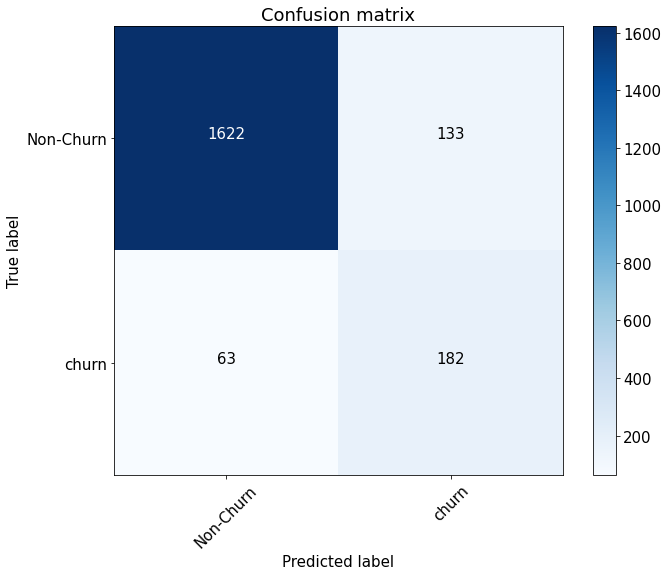

auc - 0.9355474155474156


In [210]:
# Результат на вебинаре
result['mean'] =test_result_learning(get_user_embedding)

Best Threshold=0.27650786506629904, F-Score=0.676923076923077, Precision=0.64, Recall=0.7183673469387755
Confusion matrix, without normalization
[[1656   99]
 [  70  175]]


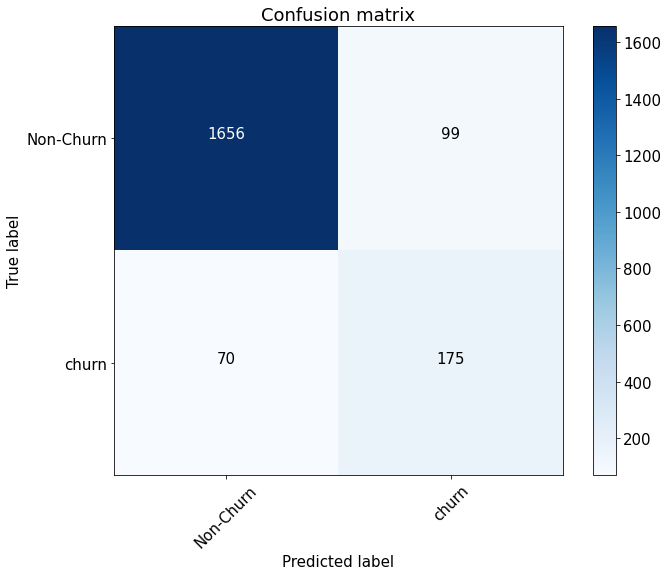

auc - 0.9499319727891157


In [211]:
# Результат с медианной
result['median']  = test_result_learning(get_user_embedding_median)

Best Threshold=0.3362919506624698, F-Score=0.7420634920634922, Precision=0.722007722007722, Recall=0.763265306122449
Confusion matrix, without normalization
[[1683   72]
 [  59  186]]


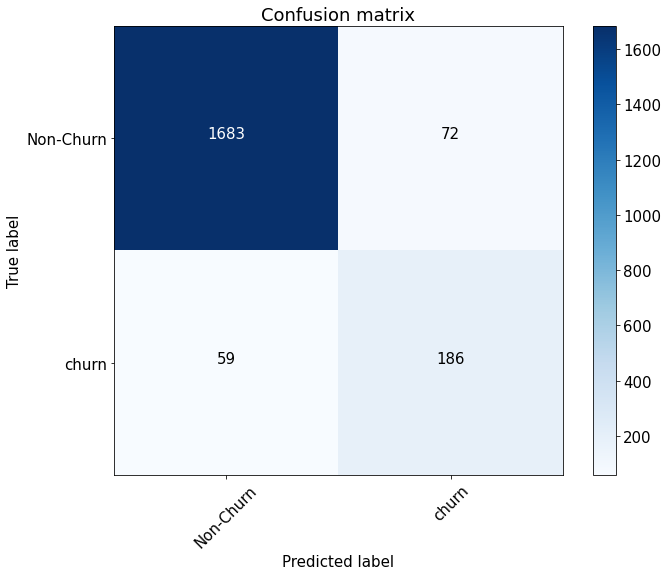

auc - 0.9640072097214955


In [212]:
# Результат с max
result['max'] = test_result_learning(get_user_embedding_max)

In [213]:
res = pd.DataFrame(result)

In [215]:
res.index = ['roc_auc','f_score','pres','rec']

In [216]:
res

,mean,median,max
roc_auc,0.935547,0.949932,0.964007
f_score,0.652406,0.676923,0.742063
pres,0.579114,0.640000,0.722008
rec,0.746939,0.718367,0.763265


Как видно при медиане показатели улучшились, а при использовании max еще более улучшились

# Эксперименты с  Idf

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
tfidf = TfidfVectorizer()

In [52]:
tp = pd.DataFrame()

In [53]:
tp['docs_id']=news['doc_id']

In [54]:
my_tfidf = tfidf.fit_transform(news['title'].apply(lambda x: ', '.join(x),1))

In [55]:
%%time
my_vector=[]
for i in my_tfidf:
    a=np.where(i.toarray()!=0)[1]
    my_vector.append(tfidf.idf_[a].mean())
    
    

Wall time: 41.5 s


In [56]:
tp['weight'] = my_vector

In [61]:
tp

,docs_id,weight
0,6,4.883926
1,4896,4.965397
2,4897,4.681600
3,4898,4.641682
4,4899,4.975748
...,...,...
26995,513441,4.381100
26996,513442,4.444499
26997,513443,4.431585
26998,513444,4.327533


In [60]:
tp.describe()

,docs_id,weight
count,27000.000000,27000.000000
mean,307503.343778,4.708674
std,189971.403428,0.479455
min,0.000000,3.298814
25%,288395.750000,4.401234
50%,322789.500000,4.651205
75%,475795.250000,4.968503
max,533674.000000,8.053602


In [87]:
users_=users.copy()

In [88]:
a=list(map(lambda x:eval(x),users['articles'].values))

In [107]:
users_['articles'] = a

In [108]:
users_['articles']

0       [293672, 293328, 293001, 293622, 293126, 1852]
1               [3405, 1739, 2972, 1158, 1599, 322665]
2               [1845, 2009, 2356, 1424, 2939, 323389]
3               [5933, 6186, 5055, 6977, 5206, 488389]
4                [707, 1144, 2532, 2928, 3133, 324592]
                             ...                      
7995     [323918, 323362, 323704, 323452, 324291, 251]
7996            [5532, 5860, 7755, 7140, 5182, 488337]
7997    [322811, 323898, 321858, 323345, 323491, 2193]
7998            [5436, 6092, 6891, 7045, 5320, 487379]
7999    [294096, 293759, 294178, 293544, 293921, 2909]
Name: articles, Length: 8000, dtype: object

In [109]:
users_['articles'] = users_['articles'].apply(lambda x: np.array([tp[tp['docs_id']==i]['weight'].values  for i in x]))


In [111]:
users_

,uid,articles
0,u105138,"[[4.013690172450131], [5.240918028627772], [4...."
1,u108690,"[[4.415708276944557], [4.815370600866168], [4...."
2,u108339,"[[5.059285827675876], [4.7418763327790145], [4..."
3,u101138,"[[4.709798414506177], [5.605671794967433], [4...."
4,u108248,"[[4.613264566877303], [4.813505653558882], [5...."
...,...,...
7995,u107463,"[[4.062011248159626], [4.468812254683797], [4...."
7996,u101241,"[[5.419337771687079], [5.066623625225241], [4...."
7997,u106486,"[[4.153632356951625], [4.142233019987925], [4...."
7998,u102220,"[[5.201370089849887], [5.08649834511191], [5.0..."


In [169]:
def test_result_learning_idf(fun):
    user_work = users_.copy()
    user_work['data'] = users_['articles'].apply(fun)

    X_train, X_test, y_train, y_test = train_test_split(user_work.drop(['uid','articles'], axis=1),
                                                    target['churn'], random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}, Precision={precision[ix]}, Recall={recall[ix]}')
    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    print(f'auc - {roc_auc_score(y_test, preds)}')

In [164]:
user_work

,uid,articles,data
0,105138,"[[4.013690172450131], [5.240918028627772], [4....",27.977395
1,108690,"[[4.415708276944557], [4.815370600866168], [4....",27.394214
2,108339,"[[5.059285827675876], [4.7418763327790145], [4...",27.954597
3,101138,"[[4.709798414506177], [5.605671794967433], [4....",29.340496
4,108248,"[[4.613264566877303], [4.813505653558882], [5....",28.415816
...,...,...,...
7995,107463,"[[4.062011248159626], [4.468812254683797], [4....",26.854575
7996,101241,"[[5.419337771687079], [5.066623625225241], [4....",29.497344
7997,106486,"[[4.153632356951625], [4.142233019987925], [4....",26.780185
7998,102220,"[[5.201370089849887], [5.08649834511191], [5.0...",29.325631


Best Threshold=0.1331717775049087, F-Score=nan, Precision=0.0, Recall=0.0
Confusion matrix, without normalization
[[1767    0]
 [ 233    0]]


<ipython-input-169-c305e99af4a6>:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


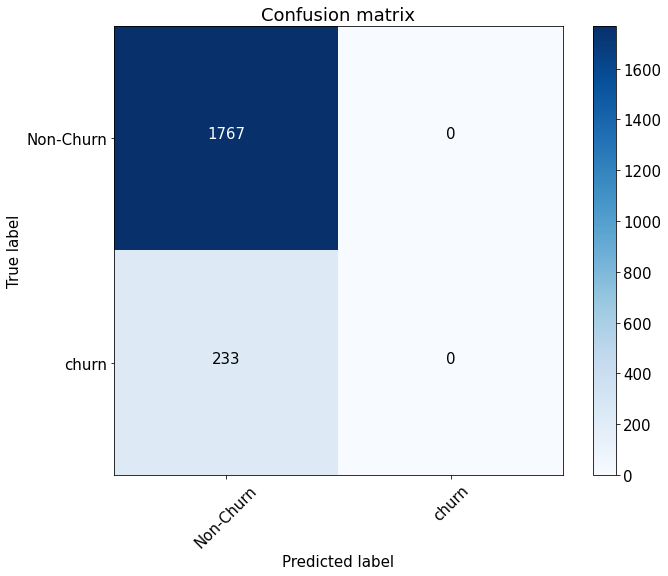

auc - 0.5112834002492039


In [170]:
test_result_learning_idf(np.mean)

Best Threshold=0.13325610062111956, F-Score=nan, Precision=0.0, Recall=0.0
Confusion matrix, without normalization
[[1767    0]
 [ 233    0]]


<ipython-input-169-c305e99af4a6>:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


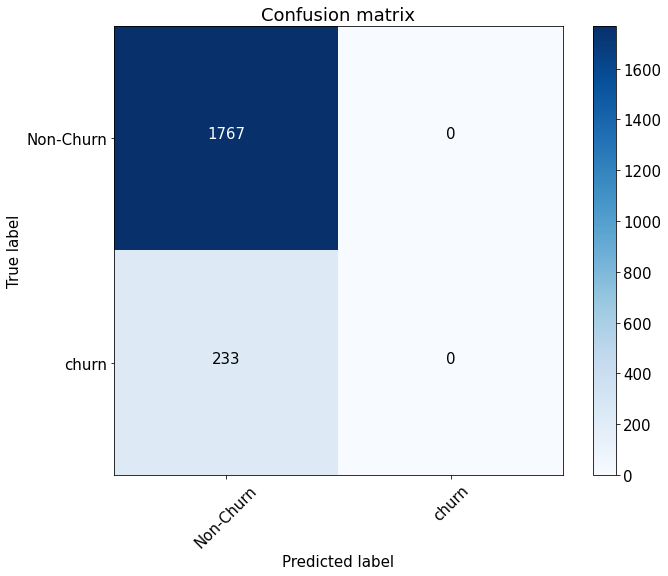

auc - 0.5112834002492039


In [171]:
test_result_learning_idf(np.sum)

<ipython-input-169-c305e99af4a6>:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.13778939576899046, F-Score=nan, Precision=0.0, Recall=0.0
Confusion matrix, without normalization
[[1763    4]
 [ 233    0]]


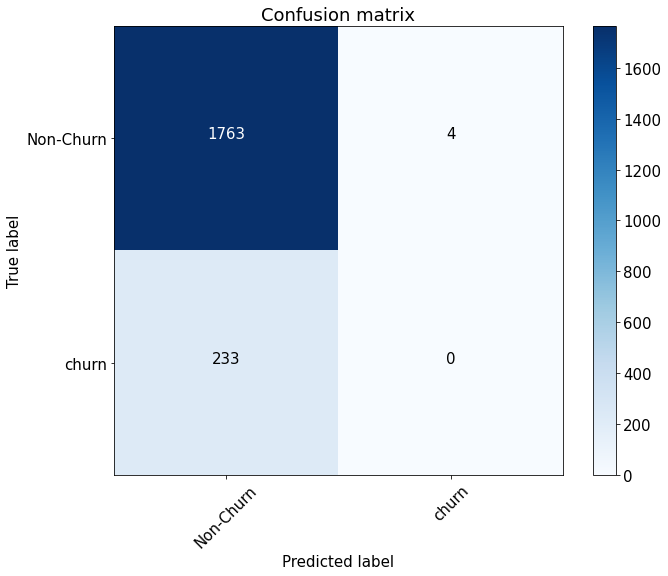

auc - 0.5169402809252122


In [172]:
test_result_learning_idf(np.median)

Best Threshold=0.12752585698795377, F-Score=0.2088749439713133, Precision=0.11661661661661661, Recall=1.0
Confusion matrix, without normalization
[[   2 1765]
 [   1  232]]


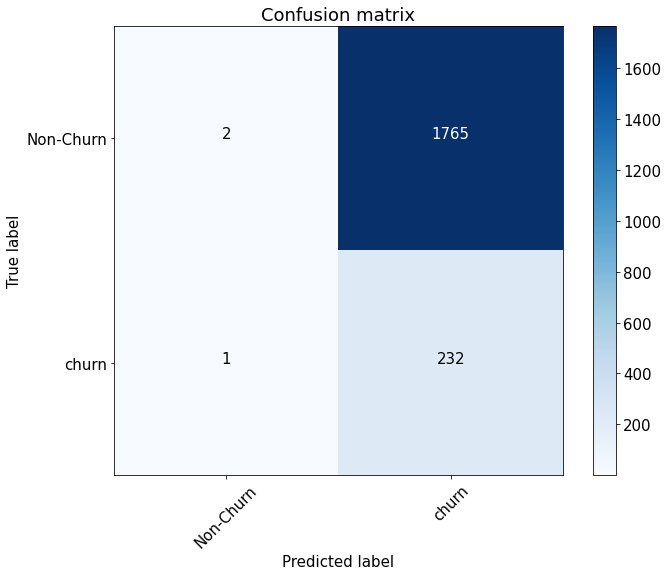

auc - 0.4846166364270083


In [173]:
test_result_learning_idf(np.max)

In [175]:
users_docs  = pd.DataFrame()

In [177]:
users_docs['user']=users['uid']

In [199]:
from tqdm import tqdm

In [200]:
for i in tqdm(news['doc_id'].values):
    vector = []
    for j in users['articles'].values:
        if i in eval(j):
            vector.append(tp[tp['docs_id']==i]['weight'].values)
        else:
            vector.append(0)
                
    users_docs[f'doc_id_{i}']   = vector
    
   

100%|████████████████████████████████████████████████████████████████████████████| 27000/27000 [48:19<00:00,  9.31it/s]


In [201]:
users_docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 27001 entries, user to doc_id_513445
dtypes: int64(12213), object(14788)
memory usage: 1.6+ GB


In [218]:
def test_result_learning_idf_matrix():

    X_train, X_test, y_train, y_test = train_test_split(users_docs.drop('user', axis=1),
                                                    target['churn'], random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}, Precision={precision[ix]}, Recall={recall[ix]}')
    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    print(f'auc - {roc_auc_score(y_test, preds)}')

<ipython-input-218-bd879f673b5e>:9: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.9700302860588527, F-Score=nan, Precision=0.0, Recall=0.0
Confusion matrix, without normalization
[[1767    0]
 [ 233    0]]


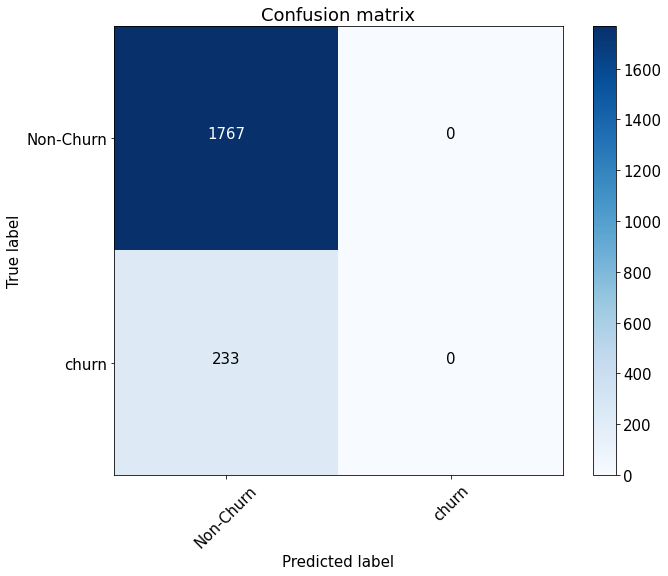

auc - 0.5079582522691888


In [219]:
test_result_learning_idf_matrix()

Ничего хорошего не получилось, либо я что то не понял